In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter
import scienceplots
plt.style.use('science')
plt.rcParams["figure.figsize"] = (4, 3)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["image.cmap"] = "turbo"

In [2]:
h = 500 # km
mu = 398600 # km^3/s^2
R_E = 6378

# Orbital velocity
def v_orb(h):
    return np.sqrt(mu / (h + 6378.1))

v = v_orb(h)
# Track velocity
v_t = v * (1 - (h/R_E))
t_span = 60 # seconds
# Axes extents
roll_angle = 20 # degrees
pitch_angle = 20 # degrees

t_s = 10 
t_dot = 1.5
t_dotsq = 3.2

def agility_linear(theta):
    return t_s + t_dot * theta

def agility_bangbang(theta):
    return t_s + t_dotsq * np.sqrt(theta)

In [3]:
def eul2dcm(roll, pitch, yaw):
    # create rotation matrices for each individual axis
    R_x = np.array([[1,         0,                  0                   ],
                    [0,         np.cos(roll), -np.sin(roll) ],
                    [0,         np.sin(roll),  np.cos(roll) ]
                    ])
    
    R_y = np.array([[np.cos(pitch),    0,      np.sin(pitch) ],
                    [0,                         1,      0                   ],
                    [-np.sin(pitch),   0,      np.cos(pitch) ]
                    ])
                
    R_z = np.array([[np.cos(yaw),    -np.sin(yaw),    0],
                    [np.sin(yaw),     np.cos(yaw),    0],
                    [0,                        0,                       1]
                    ])
    
    # combine rotations in a yaw-pitch-roll sequence
    dcm = np.dot(R_z, np.dot( R_y, R_x ))
    
    return dcm

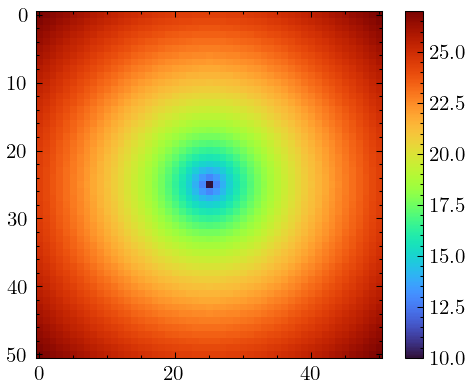

In [4]:
N = 51
plt.subplots()
roll = (np.linspace(-roll_angle, roll_angle, N))
pitch = (np.linspace(-pitch_angle, pitch_angle, N))

R, P = np.meshgrid(roll, pitch)

agility = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        dcm = eul2dcm(np.deg2rad(roll[i]), np.deg2rad(pitch[j]), 0)
        agility[i, j] = agility_bangbang(np.rad2deg(np.arccos((np.trace(dcm) - 1)/2)))

plt.imshow((agility))
plt.colorbar()
plt.show()


In [5]:
# Distance and angle between target 
N = 50
t = np.linspace(-50, 0, N)
Earth_angle = (t * v_t)/(R_E)
vec_sat = np.array([0, 0, h])
vec_target = np.vstack([R_E * np.sin(Earth_angle), np.zeros(N), (1-np.cos(Earth_angle)) * R_E])
# Angle between target and boresight
vec_target2sat_unit = vec_target - vec_sat[:, np.newaxis]
vec_target2sat_unit = -vec_target2sat_unit / np.linalg.norm(vec_target2sat_unit, axis=0)
# Angle between vectors
boresight = np.array([[0, 0, 1]]).T
angle_pitch = np.rad2deg(np.arccos(np.sum(boresight * vec_target2sat_unit, axis=0))) - 20 # 20 deg boresight

dist = (np.linalg.norm(vec_sat[:, np.newaxis] - vec_target, axis=0))

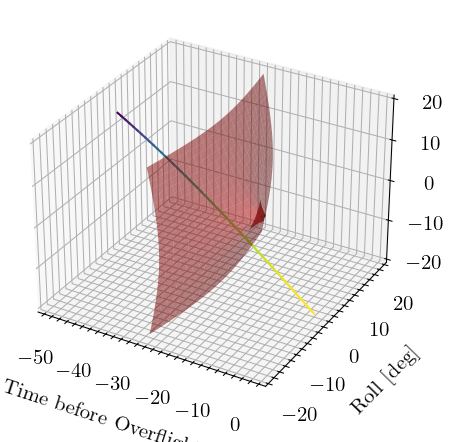

In [8]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Normalize color data
norm = plt.Normalize(dist.min(), dist.max())
cmap = plt.get_cmap('viridis')

# Plot each segment with its own color
for i in range(len(dist)-1):
    ax.plot(t[i:i+2], 0, angle_pitch[i:i+2], color=cmap(1-norm(dist[i])))


ax.plot_surface(-agility, R, P, alpha=.5, color='r')
ax.set_ylabel("Roll [deg]")
ax.set_zlabel("Pitch [deg]")
ax.set_xlabel("Time before Overflight [s]")

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Distance')

plt.tight_layout()
plt.savefig("agility_contraint.png",dpi=300)
plt.show()